In [4]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.neural_network import MLPClassifier as MLP

In [95]:
def checker_board(pos_num, ratio=10., var=0.1):
    u_xs = [0.5, 1.5, 2.5, 3.5]
    u_ys = [0.5, 1.5, 2.5, 3.5]
    X = []
    Y = []
    cov = [[var, 0.], [0., var]]
    for i, u_x in enumerate(u_xs):
        for j, u_y in enumerate(u_ys):
            if (i+j)%2==0: # generate negative samples
                x = np.random.multivariate_normal([u_x, u_y], cov, size=pos_num*ratio)
                y = [0]*len(x)
                X += list(x)
                Y += y
            else:
                x = np.random.multivariate_normal([u_x, u_y], cov, size=pos_num)
                y = [1]*len(x)
                X += list(x)
                Y += y
    X, Y = np.array(X), np.array(Y)
    idxes = np.arange(len(X))
    np.random.shuffle(idxes)
    return X[idxes], Y[idxes]

In [80]:
# Report results
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support, make_scorer
from imblearn.metrics import classification_report_imbalanced

def evaluate_f1(y, y_pred, pos_label=1):
    f1 = f1_score(y, y_pred, pos_label=1, average='macro')
    return f1

f1_scorer = make_scorer(evaluate_f1, greater_is_better=True)

def evaluate_imbalance(y, y_pred):
    results = classification_report_imbalanced(y, y_pred)
    print(results)

In [58]:
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC as SVM
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT

### Generate data with different imbalanced ratio

In [251]:
imblance_ratio = 50

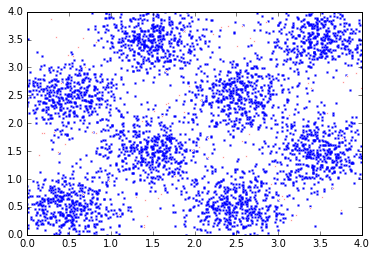

In [252]:
import pickle
import os

if os.path.exists('../data/synthetic/checkerboard/train_{}.pkl'.format(imblance_ratio)):
    train = pickle.load(open('../data/synthetic/checkerboard/train_{}.pkl'.format(imblance_ratio), 'rb'))
    train_x, train_y = train[b'x'], np.argmax(train[b'y'], axis=1)
else:
    train_x, train_y = checker_board(pos_num=10, ratio=imblance_ratio, var=0.1) 
    pickle.dump({'x':train_x, 'y':np.eye(2)[train_y.astype('int32')]}, 
                open('../data/synthetic/checkerboard/train_{}.pkl'.format(imblance_ratio), 'wb+'))
x = train_x
y = train_y
area = np.pi
plt.scatter(x[y==0][:, 0], x[y==0][:, 1], c="b", marker='x', s=area, edgecolors='w')
plt.scatter(x[y==1][:, 0], x[y==1][:, 1], c="r", marker='o', s=area, edgecolors='w')
plt.axis([0, 4, 0, 4])
plt.show()

In [253]:
# Choose hyper-parameters with cross validation
# Supervised Model: SVM
# Dataset: original
from sklearn.model_selection import cross_val_score

best_c = 0
best_reward = 0
for c in [1e2, 1e3, 1e4]:
    clf = SVM(C=c, kernel='rbf', random_state=0)
    reward = np.array(cross_val_score(clf, train_x, train_y, cv=5, n_jobs=5, scoring=f1_scorer)).mean()
    print('reward:{}'.format(reward))
    if reward > best_reward:
        best_reward = reward
        best_c = c
print 'best_c:{}'.format(best_c)
print 'best_reward:{}'.format(best_reward)

/home/leshare/softwares/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/leshare/softwares/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/leshare/softwares/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/leshare/softwares/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', ave

reward:0.494861674636


/home/leshare/softwares/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


reward:0.529038865005
reward:0.547146635026
best_c:10000.0
best_reward:0.547146635026


train reward:0.564320403901


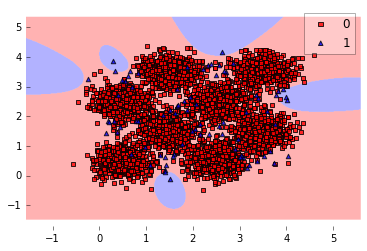

In [254]:
# Get train reward with the chosen hyper-parameter
from mlxtend.plotting import plot_decision_regions
clf = SVM(C=best_c, kernel='rbf', random_state=0)
clf.fit(train_x, train_y) 
preds = clf.predict(train_x)
reward = evaluate_f1(train_y, preds)
print('train reward:{}'.format(reward))
plot_decision_regions(train_x, train_y.astype('int32'), clf=clf, legend=1)
plt.show()

### Plot Classification Boundary: Original v.s RL

In [259]:
clf = SVM(C=1e4, kernel='rbf', random_state=0)
for i, imblance_ratio in enumerate([5, 10, 25, 50]):
    train = pickle.load(open('../data/synthetic/checkerboard/train_{}.pkl'.format(imblance_ratio), 'rb'))
    x_all, y_all = train[b'x'], np.argmax(train[b'y'], axis=1)
    weights = np.load(open('weight_{}.npy'.format(imblance_ratio), 'rb'))
    x = x_all[weights==1]
    y = y_all[weights==1]
    # plot boundary on original dataset
    clf.fit(x_all, y_all)
    plot_decision_regions(x_all, y_all.astype('int32'), markers='x^', clf=clf, legend=0,
                      colors='r,b,limegreen,gray,cyan',
                      scatter_kwargs={'c':'rb', 's':[3, 3], 'linewidths':[1, 1]},
                     contourf_kwargs={'colors':'r', 'cmap':None})
    plt.axis([0., 4., 0., 4.])
    plt.xticks(np.arange(0, 5, 1))
    plt.yticks(np.arange(0, 5, 1))
    plt.tight_layout()
    plt.savefig('../paper/imgs/org_{}.png'.format(imblance_ratio), bbox_inches='tight')
    plt.savefig('../paper/imgs/org_{}.pdf'.format(imblance_ratio), bbox_inches='tight')
    plt.close()
    # plot boundary on subset
    clf.fit(x, y) 
    plot_decision_regions(x, y.astype('int32'), markers='x^', clf=clf, legend=0,
                      colors='r,b,limegreen,gray,cyan',
                      scatter_kwargs={'c':'rb', 's':[3, 3], 'linewidths':[1, 1]},
                     contourf_kwargs={'colors':'r', 'cmap':None})
    plt.axis([0., 4., 0., 4.])
    plt.xticks(np.arange(0, 5, 1))
    plt.yticks(np.arange(0, 5, 1))
    plt.tight_layout()
    plt.savefig('../paper/imgs/sub_{}.png'.format(imblance_ratio), bbox_inches='tight')
    plt.savefig('../paper/imgs/sub_{}.pdf'.format(imblance_ratio), bbox_inches='tight')
    plt.close()

In [228]:
train = pickle.load(open('../data/synthetic/checkerboard/train_25.pkl'.format(imblance_ratio), 'rb'))
x_all, y_all = train[b'x'], np.argmax(train[b'y'], axis=1)
weights = np.load(open('weight_25.npy'.format(imblance_ratio), 'rb'))
x = x_all[weights==1]
y = y_all[weights==1]

train reward:0.773534338358


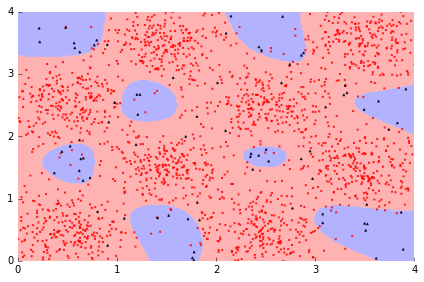

In [236]:
# fit on chosen subset and plot on original dataset
clf = SVM(C=1e4, kernel='rbf', random_state=0)
clf.fit(x, y) 
preds = clf.predict(x_all)
reward = evaluate_f1(y_all, preds)
print('train reward:{}'.format(reward))
plot_decision_regions(x_all, y_all.astype('int32'), markers='x^', clf=clf, legend=0,
                      colors='r,b,limegreen,gray,cyan',
                      scatter_kwargs={'c':'rb', 's':[3, 3], 'linewidths':[1, 1]},
                     contourf_kwargs={'colors':'r', 'cmap':None})
plt.axis([0., 4., 0., 4.])
plt.xticks(np.arange(0, 5, 1))
plt.yticks(np.arange(0, 5, 1))
plt.tight_layout()
#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.savefig('tmp.pdf', bbox_inches='tight')
plt.show()

train reward:0.665624979781


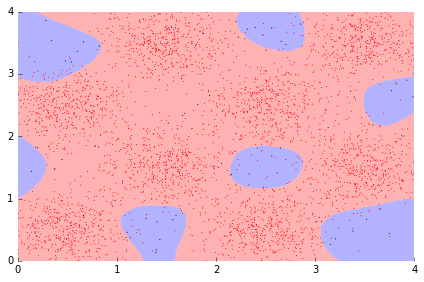

In [275]:
# fit on original subset and plot on original dataset

from imblearn.under_sampling import (NearMiss, RandomUnderSampler, EditedNearestNeighbours, 
                                     CondensedNearestNeighbour, ClusterCentroids, TomekLinks,
                                     RepeatedEditedNearestNeighbours, AllKNN)
from imblearn.pipeline import make_pipeline
from collections import Counter

clf = SVM(C=1e4, kernel='rbf', random_state=0)
pos_num = (y_all==1).sum()


train_x_s, train_y_s = RandomUnderSampler(ratio={0:int(10*pos_num)}).fit_sample(x_all, y_all)
clf.fit(train_x_s, train_y_s)
preds = clf.predict(x_all)
reward = evaluate_f1(y_all, preds)
print('train reward:{}'.format(reward))
#clf.fit(x_all, y_all) 
plot_decision_regions(x_all, y_all.astype('int32'), markers='x^', clf=clf, legend=0,
                      colors='r,b,limegreen,gray,cyan',
                      scatter_kwargs={'c':'rb', 's':[0.5, 0.5], 'linewidths':[0.5, 0.5]},
                     contourf_kwargs={'colors':'r', 'cmap':None})
#clf.fit(x, y) 
#plot_decision_regions(x_all, y_all.astype('int32'), markers='x^', clf=clf, legend=0,
#                      colors='cyan,limegreen,b,gray,cyan',
#                      scatter_kwargs={'c':'rb', 's':[0.5, 0.5], 'linewidths':[0.5, 0.5]},
#                     contourf_kwargs={'colors':'r', 'cmap':None})
plt.axis([0., 4., 0., 4.])
plt.xticks(np.arange(0, 5, 1))
plt.yticks(np.arange(0, 5, 1))
plt.tight_layout()
plt.show()

train reward:0.812405290869


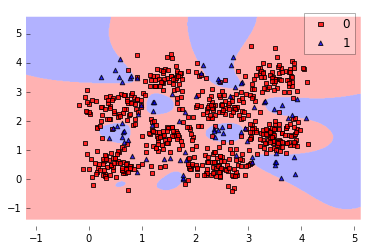

In [160]:
clf = SVM(C=1e4, kernel='rbf', random_state=0)
clf.fit(x, y) 
preds = clf.predict(x)
reward = evaluate_f1(y, preds)
print('train reward:{}'.format(reward))
plot_decision_regions(x, y.astype('int32'), clf=clf, legend=1)
plt.show()

train reward:0.610961480911


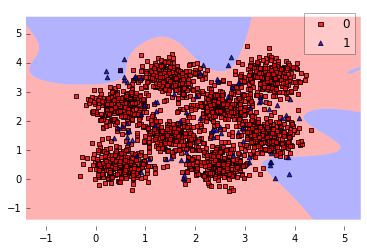

In [159]:
clf = SVM(C=1e4, kernel='rbf', random_state=0)
clf.fit(x_all, y_all) 
preds = clf.predict(x_all)
reward = evaluate_f1(y_all, preds)
print('train reward:{}'.format(reward))
plot_decision_regions(x_all, y_all.astype('int32'), clf=clf, legend=1)
plt.show()